In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir = pathlib.Path("../src/archive/brain_tumor_dataset")
data_dir

WindowsPath('../src/archive/brain_tumor_dataset')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

245


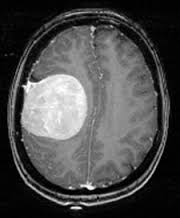

In [4]:
yes = list(data_dir.glob('yes/*'))
PIL.Image.open(str(yes[0]))

In [18]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)




Found 253 files belonging to 2 classes.
Using 190 files for training.


In [19]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 253 files belonging to 2 classes.
Using 63 files for validation.


In [20]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


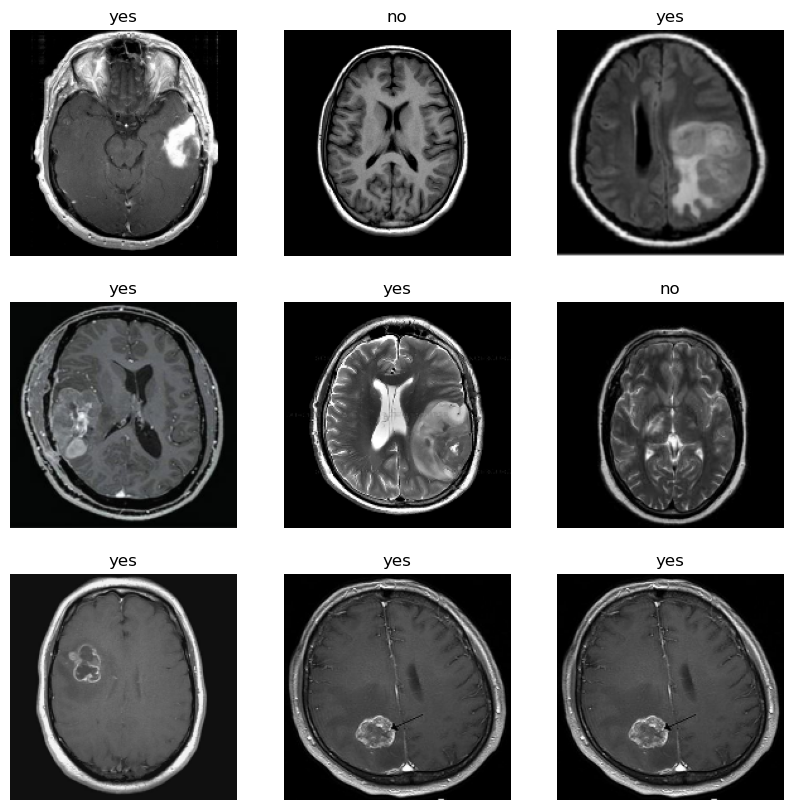

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [23]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [24]:
first_image = image_batch[6]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96684873


In [25]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [27]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
6/6 [==============================] - 1s 156ms/step - loss: 0.8532 - accuracy: 0.5737 - val_loss: 0.5630 - val_accuracy: 0.7143
Epoch 2/10
6/6 [==============================] - 1s 122ms/step - loss: 0.4707 - accuracy: 0.8158 - val_loss: 0.5908 - val_accuracy: 0.7778
Epoch 3/10
6/6 [==============================] - 1s 118ms/step - loss: 0.4576 - accuracy: 0.8053 - val_loss: 0.5549 - val_accuracy: 0.7778
Epoch 4/10
6/6 [==============================] - 1s 122ms/step - loss: 0.4153 - accuracy: 0.8053 - val_loss: 0.5580 - val_accuracy: 0.7937
Epoch 5/10
6/6 [==============================] - 1s 117ms/step - loss: 0.3801 - accuracy: 0.8316 - val_loss: 0.5330 - val_accuracy: 0.7937
Epoch 6/10
6/6 [==============================] - 1s 133ms/step - loss: 0.3147 - accuracy: 0.8684 - val_loss: 0.5337 - val_accuracy: 0.8095
Epoch 7/10
6/6 [==============================] - 1s 124ms/step - loss: 0.2463 - accuracy: 0.9105 - val_loss: 0.6381 - val_accuracy: 0.8095
Epoch 8/10
6/6 [====

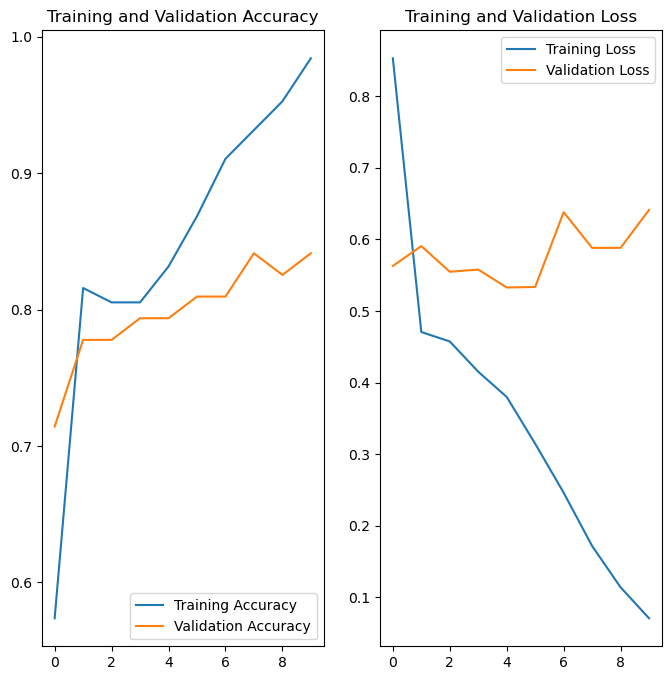

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()